In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import training
import models
import metrics
from models import SpatioTemporalAutoencoder, TRACE_GRU
from parameters import STAEParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_TRACE_GRU, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os
seed=42
torch_geometric.seed_everything(seed)


def sequence_stae(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(Data(x=torch.tensor(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy(), dtype=torch.float32), edge_index=static_edges)) # assumes time indices come sequentially, with full data it may not

        curr_graph = data_t[0]
        sequence.append([data_t[::-1], curr_graph])

    return sequence, kept_indices

hide_anomalies = True
optimal_params = load_best_parameters('TRACE_GRU',hide_anomalies=hide_anomalies)
print(optimal_params)
training_params = TrainingParameters(
    learning_rate=optimal_params['learning_rate'],
    batch_size=1,
    timesteps=optimal_params['timesteps'],
    n_epochs=optimal_params['epochs'],
)

/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'dropout_rate': 0.4942638796811494, 'epochs': 9, 'flow_layers': 4, 'hidden_dim': 32, 'learning_rate': 3.908557813906214e-06, 'n_hidden_flow': 3, 'num_gcn_layers': 1, 'num_transformer_layers': 2, 'output_dim': 128, 'timesteps': 7}


In [2]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_stae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_stae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)


100%|██████████| 2873/2873 [00:10<00:00, 273.77it/s]


In [3]:


num_features = 3
num_nodes = 196

model_params = {
    'input_features': num_features,
    'num_sensors': num_nodes,
    'hidden_dim': optimal_params['hidden_dim'],
    'num_transformer_layers': optimal_params['num_transformer_layers'],
    'output_dim': optimal_params['output_dim'],
    'num_gcn_layers': optimal_params['num_gcn_layers'],
    'flow_layers': optimal_params['flow_layers'],
    'n_hidden_flow':optimal_params['n_hidden_flow'],
    'dropout_rate':optimal_params['dropout_rate'],

    
}
using_pretrained = True

  0%|          | 0/9 [00:00<?, ?it/s]/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 11%|█         | 1/9 [02:35<20:44, 155.61s/it]

Epoch number 0 last 100 loss -297.0928546142578


 22%|██▏       | 2/9 [04:27<15:09, 129.93s/it]

Epoch number 1 last 100 loss -509.35815185546875


 33%|███▎      | 3/9 [06:19<12:10, 121.76s/it]

Epoch number 2 last 100 loss -639.9823742675782


 44%|████▍     | 4/9 [08:11<09:49, 117.98s/it]

Epoch number 3 last 100 loss -691.7062530517578


 56%|█████▌    | 5/9 [11:27<09:43, 145.84s/it]

Epoch number 4 last 100 loss -718.1358795166016


 67%|██████▋   | 6/9 [14:28<07:53, 157.98s/it]

Epoch number 5 last 100 loss -748.2579949951172


 78%|███████▊  | 7/9 [17:46<05:42, 171.06s/it]

Epoch number 6 last 100 loss -771.5042510986328


 89%|████████▉ | 8/9 [21:05<03:00, 180.03s/it]

Epoch number 7 last 100 loss -793.0325347900391


100%|██████████| 9/9 [24:25<00:00, 162.85s/it]

Epoch number 8 last 100 loss -815.561185913086


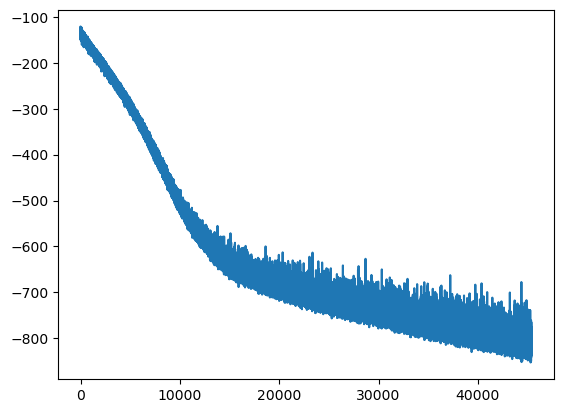

In [4]:


if not using_pretrained:
    model, losses= train_TRACE_GRU(model_params, training_params, train_sequence,verbose=True)
    save_model(model, f'TRACE_GRU_{hide_anomalies}_{seed}' )
    plt.plot(losses)

else:
    # model=FixedGraphTransformerNormalizingFlow(**model_params)
    model = load_model(TRACE_GRU,model_params,f'TRACE_GRU_{hide_anomalies}_{seed}')
    

    

In [5]:

thresh = training.compute_threshold_f_gtnf(val_sequence,model , 'max')

In [6]:
_, df_test_data, _ = get_full_data()
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_stae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4793/4793 [00:30<00:00, 158.16it/s]


In [7]:
test_errors=training.test_f_gtnf(test_data, model, verbose=True)


100%|██████████| 4763/4763 [00:37<00:00, 126.64it/s]


In [8]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [9]:
path_results = 'saved_results/TRACE_GRU/'
results = metrics.discrete_fp_delays_nll(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

100%|██████████| 10000/10000 [05:03<00:00, 32.99it/s]

Found FPR of 0.007462686567164179 for 0.01
Found FPR of 0.02321724709784411 for 0.025
Found FPR of 0.0472636815920398 for 0.05
Found FPR of 0.10157545605306799 for 0.1
Found FPR of 0.20024875621890548 for 0.2
FPR 1% gives mean delay of 7.0 +/- 0.0 while missing 0.9166666666666666%.
FPR 2.5% gives mean delay of 9.166666666666666 +/- 2.0548046676563256 while missing 0.75%.
FPR 5% gives mean delay of 4.583333333333333 +/- 8.079896176450674 while missing 0.5%.
FPR 10% gives mean delay of -2.3333333333333335 +/- 7.4981479194679945 while missing 0.25%.
FPR 20% gives mean delay of -11.666666666666666 +/- 3.8297084310253524 while missing 0.25%.


In [10]:
calculate_auc(test_errors,anomaly_labels)

0.6592922732018918